# SP LIME

## Regression explainer with boston housing prices dataset

In [1]:
from sklearn.datasets import load_boston
import sklearn.ensemble
import sklearn.linear_model
import sklearn.model_selection
import numpy as np
from sklearn.metrics import r2_score
np.random.seed(1)

#load example dataset
boston = load_boston()

#print a description of the variables
print(boston.DESCR)

#train a regressor
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=1000)
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(boston.data, boston.target, train_size=0.80, test_size=0.20)
rf.fit(train, labels_train);

#train a linear regressor
lr = sklearn.linear_model.LinearRegression()
lr.fit(train,labels_train)

#print the R^2 score of the random forest
print("Random Forest R^2 Score: " +str(round(r2_score(rf.predict(test),labels_test),3)))
print("Linear Regression R^2 Score: " +str(round(r2_score(lr.predict(test),labels_test),3)))

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

/Users/marcotcr/phd/lime/ENV/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Random Forest R^2 Score: 0.882
Linear Regression R^2 Score: 0.593


In [2]:
# import lime tools
import lime
import lime.lime_tabular

# generate an "explainer" object
categorical_features  = np.argwhere(np.array([len(set(boston.data[:,x])) for x in range(boston.data.shape[1])]) <= 10).flatten()
explainer = lime.lime_tabular.LimeTabularExplainer(train, feature_names=boston.feature_names, class_names=['price'], categorical_features=categorical_features, verbose=False, mode='regression',discretize_continuous=False)

In [3]:
#generate an explanation
i = 13
exp = explainer.explain_instance(test[i], rf.predict, num_features=14)

/Users/marcotcr/phd/lime/ENV/lib/python2.7/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


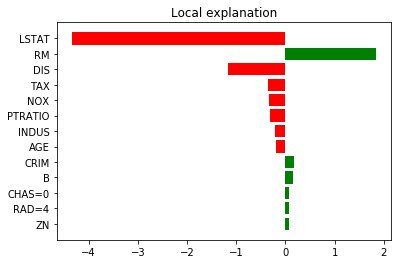

In [4]:
%matplotlib inline
fig = exp.as_pyplot_figure();

In [5]:
print("Input feature names: ")
print(boston.feature_names)
print('\n')

print("Input feature values: ")
print(test[i])
print('\n')

print("Predicted: ")
print(rf.predict(test)[i])

Input feature names: 
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


Input feature values: 
[  4.37900000e-02   8.00000000e+01   3.37000000e+00   0.00000000e+00
   3.98000000e-01   5.78700000e+00   3.11000000e+01   6.61150000e+00
   4.00000000e+00   3.37000000e+02   1.61000000e+01   3.96900000e+02
   1.02400000e+01]


Predicted: 
20.1622


# SP-LIME pick step

### Maximize the 'coverage' function:

$c(V,W,I) = \sum_{j=1}^{d^{\prime}}{\mathbb{1}_{[\exists i \in V : W_{ij}>0]}I_j}$

$W = \text{Explanation Matrix,  } n\times d^{\prime}$

$V = \text{Set of chosen explanations}$

$I = \text{Global feature importance vector,   } I_j = \sqrt{\sum_i{|W_{ij}|}}$

In [7]:
import lime

In [8]:
import warnings
from lime import submodular_pick
sp_obj = submodular_pick.SubmodularPick(explainer, train, rf.predict, sample_size=20, num_features=14,num_exps_desired=5)

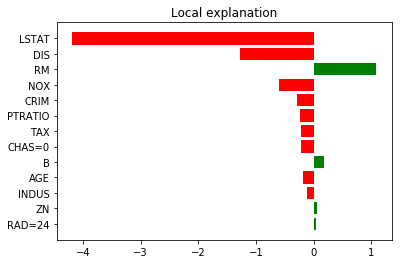

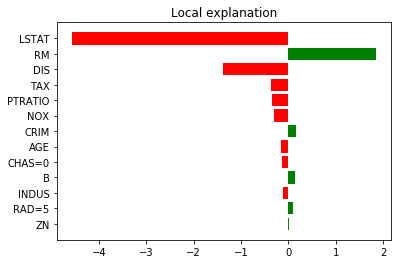

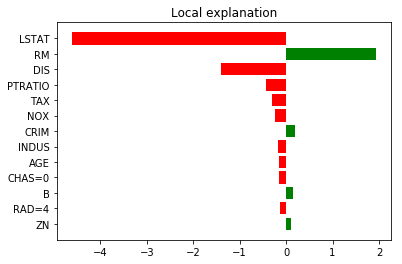

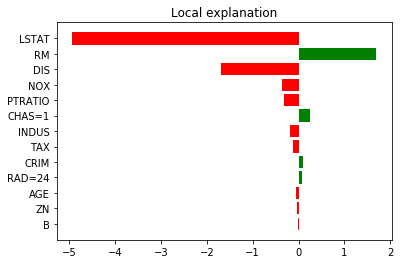

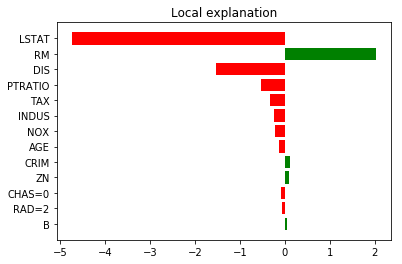

In [9]:
[exp.as_pyplot_figure() for exp in sp_obj.sp_explanations];

In [10]:
import pandas as pd
W=pd.DataFrame([dict(this.as_list()) for this in sp_obj.explanations])

In [11]:
W.head()

,AGE,B,CHAS=0,CHAS=1,CRIM,DIS,INDUS,LSTAT,NOX,PTRATIO,RAD=2,RAD=24,RAD=3,RAD=4,RAD=5,RAD=7,RM,TAX,ZN
0,-0.057870,-0.000680,NaN,0.248645,0.096433,-1.688421,-0.192365,-4.941001,-0.352047,-0.324941,NaN,0.065437,NaN,NaN,NaN,NaN,1.695661,-0.123172,-0.039653
1,-0.123627,0.058122,-0.079254,NaN,0.109252,-1.532825,-0.240987,-4.742649,-0.214497,-0.518830,-0.067654,NaN,NaN,NaN,NaN,NaN,2.035927,-0.323958,0.091031
2,-0.181614,0.050144,0.051142,NaN,0.021977,-1.458347,-0.115555,-4.993308,-0.500125,-0.317091,NaN,0.132283,NaN,NaN,NaN,NaN,1.391057,-0.145964,0.058307
3,-0.181754,0.031631,0.031895,NaN,0.233783,-1.145737,-0.120627,-4.401081,-0.180770,-0.414619,NaN,NaN,NaN,0.018298,NaN,NaN,2.040147,-0.292597,-0.032811
4,-0.116000,0.100807,-0.288901,NaN,0.292766,-1.612013,-0.156357,-4.790155,-0.252993,-0.400579,NaN,NaN,NaN,-0.007299,NaN,NaN,1.940067,-0.359989,0.017763


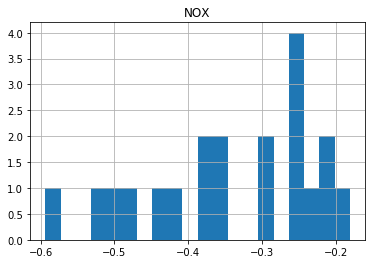

In [12]:
im=W.hist('NOX',bins=20)

## Text explainer using the newsgroups

In [13]:
# run the text explainer example notebook, up to single explanation
import sklearn
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
from __future__ import print_function

from sklearn.datasets import fetch_20newsgroups
categories = ['alt.atheism', 'soc.religion.christian']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
class_names = ['atheism', 'christian']

vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_vectors, newsgroups_train.target)

pred = rf.predict(test_vectors)
sklearn.metrics.f1_score(newsgroups_test.target, pred, average='binary')

from lime import lime_text
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, rf)

from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

idx = 83
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6)
print('Document id: %d' % idx)
print('Probability(christian) =', c.predict_proba([newsgroups_test.data[idx]])[0,1])
print('True class: %s' % class_names[newsgroups_test.target[idx]])

Document id: 83
Probability(christian) = 0.444
True class: atheism


In [14]:
sp_obj = submodular_pick.SubmodularPick(explainer, newsgroups_test.data, c.predict_proba, sample_size=2, num_features=6,num_exps_desired=2,top_labels=3)

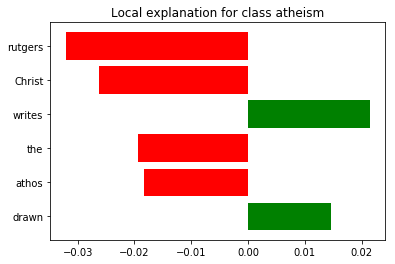

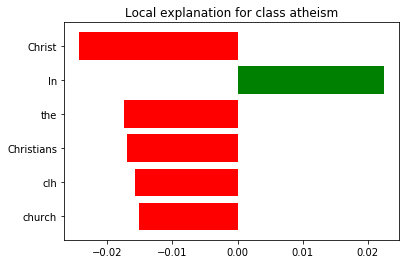

In [15]:
[exp.as_pyplot_figure(label=0) for exp in sp_obj.sp_explanations];

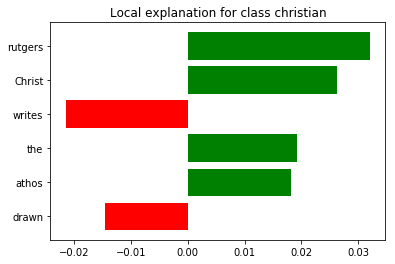

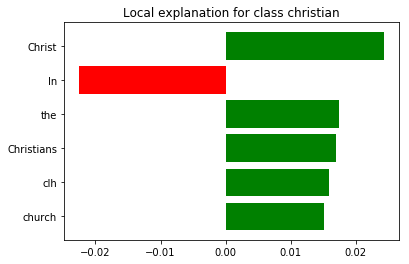

In [16]:
[exp.as_pyplot_figure(label=1) for exp in sp_obj.sp_explanations];

In [17]:
from sklearn.datasets import load_iris
iris=load_iris()
from sklearn.cross_validation import train_test_split as tts
Xtrain,Xtest,ytrain,ytest=tts(iris.data,iris.target,test_size=.2)
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(Xtrain,ytrain)
rf.score(Xtest,ytest)

/Users/marcotcr/phd/lime/ENV/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.83333333333333337

In [18]:
explainer = lime.lime_tabular.LimeTabularExplainer(Xtrain, 
                                                   feature_names=iris.feature_names,
                                                   class_names=iris.target_names, 
                                                   verbose=False, 
                                                   mode='classification',
                                                   discretize_continuous=False)

In [19]:
exp=explainer.explain_instance(Xtrain[i],rf.predict_proba,top_labels=3)
exp.available_labels()

[1, 2, 0]

In [20]:
sp_obj = submodular_pick.SubmodularPick(data=Xtrain,explainer=explainer,num_exps_desired=5,predict_fn=rf.predict_proba, sample_size=20, top_labels=3, num_features=4)

In [21]:
import pandas as pd
df=pd.DataFrame({})
for this_label in range(3):
    dfl=[]
    for i,exp in enumerate(sp_obj.sp_explanations):
        l=exp.as_list(label=this_label)
        l.append(("exp number",i))
        dfl.append(dict(l))
    dftest=pd.DataFrame(dfl)
    df=df.append(pd.DataFrame(dfl,index=[iris.target_names[this_label] for i in range(len(sp_obj.sp_explanations))]))
df

,exp number,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm)
setosa,0,-0.082228,-0.236923,-0.032294,0.012060
setosa,1,-0.090088,-0.260716,-0.025831,0.012220
setosa,2,-0.061403,-0.203016,-0.032648,0.008165
setosa,3,-0.115855,-0.326017,-0.043795,0.021527
setosa,4,-0.108132,-0.319248,-0.043905,0.014563
versicolor,0,-0.180320,0.074353,0.047606,-0.000603
versicolor,1,-0.130953,0.108325,0.049563,-0.012690
versicolor,2,-0.224952,0.035047,0.027544,-0.009744
versicolor,3,-0.009624,0.215826,0.085704,-0.021219
versicolor,4,-0.032447,0.207419,0.082044,-0.020580
